# Esonero 2 - 17 Maggio 2021

Completare i seguenti esercizi tramite uno o più blocchi di codice descrivendo le operazioni effettuate


# Esercizio 1

Data la seguente immagine, costruire la feature pyramid di gaussiane e descrivere il procedimento

![](figure1.jpg)

In [1]:
## SIFT
import cv2
import skimage
import numpy as np
from skimage import color

## HARRIS
import cv2
import skimage
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import convolve, correlate, filters
import matplotlib.pyplot as plt
from matplotlib import image as mp_image

## NN
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score

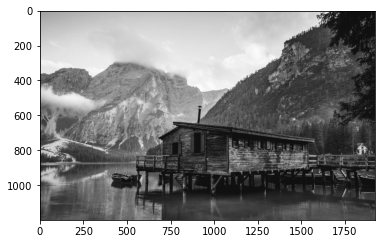

In [2]:
image = mp_image.imread('figure1.jpg')

gray_image = color.rgb2gray(image)

#normalizzo l'immagine
maxv, minv = np.max(gray_image), np.min(gray_image)
gray_image = (gray_image - minv)/(maxv-minv)

plt.imshow(gray_image, cmap='gray')

In [3]:
print(gray_image.shape)

(1200, 1920)


Per la costruzione della piramide gaussiana gli step da fare sono sostanzialmente due: applicare all'immagine iniziale un filtro gaussiano con un certo sigma e dimezzare la dimensione. Si procede raddoppiando tale sigma e riapplicandolo sempre all'immagine originale ma si dimezza l'immagine rispetto alla precedente.

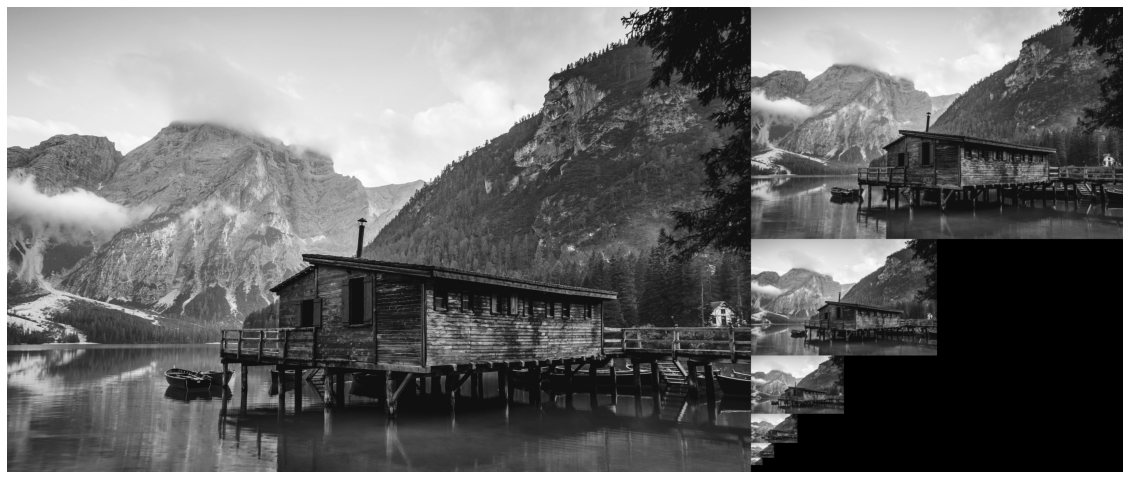

In [4]:
rows,cols = gray_image.shape

output = np.zeros((rows,cols+cols//2))

output[:rows,:cols] = gray_image

num_octave = 6

cur_scale = image

horiz = True
rows = 0

for i in range(num_octave):
    sigma = 2**i
    cur_scale = ndimage.gaussian_filter(gray_image,sigma)
    cur_scale = cur_scale[::2**(i+1),::2**(i+1)]
    rows_scaled, cols_scaled = cur_scale.shape
    output[rows:rows+rows_scaled,cols:cols+cols_scaled] = cur_scale
    rows += rows_scaled
        
        
plt.figure(figsize=(20, 20))

plt.imshow(output,cmap='gray')
plt.axis('off')
plt.show()

L'immagine sopra rappresenta la piramide gaussiana costruita con il procedimento sopra descritto.
L'immagine a sinistra rappresenta quella originale a cui abbiamo ogni volta applicato il filtro gaussiano, mentre a destra vediamo la piramide, quindi i risultati dei filtri e dei dimezzamenti.

Alternativamente, invece di applicare ogni volta un filtro gaussiano all'immagine originale con un sigma che cresce esponenzialmente, possiamo fissare un valore di sigma e applicarlo in cascata. Contemporaneamente si dimezza la dimensione:

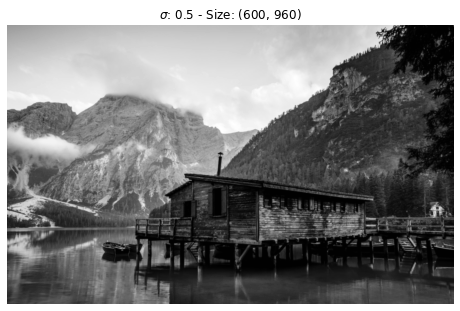

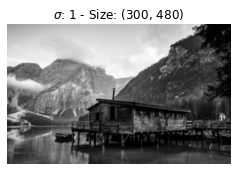

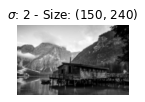

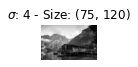

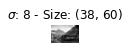

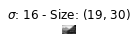

In [5]:
size = 8
num_octave = 6

cur_scale = np.copy(gray_image)

sigma = 1 #applico sempre questo, senza aggiornarlo ad ogni iterazione

for i in range(num_octave):
    cur_scale = ndimage.gaussian_filter(cur_scale,sigma)
    cur_scale = cur_scale[::2,::2]
    
    plt.figure(figsize=(size, size))
    plt.imshow(cur_scale,cmap='gray')
    s = 2*np.ceil(3*2**(i-1))+1
    plt.title(f'$\sigma$: {2**(i-1)} - Size: {cur_scale.shape}')
    plt.axis('off')
    plt.show()
    
    size = size/2

Se volessimo rappresentare questa piramide gaussiana in forma compatta (come visto all'inizio):

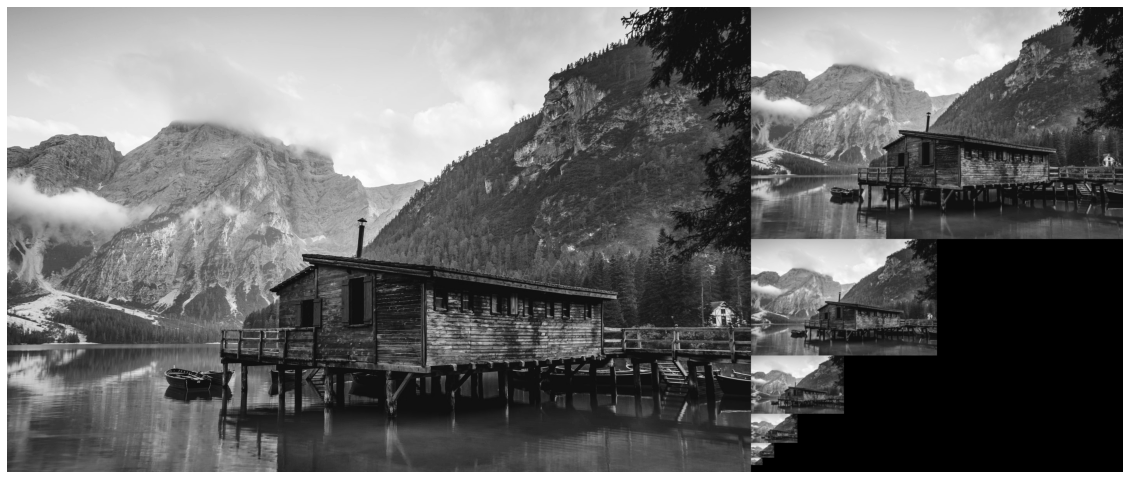

In [6]:
rows,cols = gray_image.shape

output = np.zeros((rows,cols+cols//2))

output[:rows,:cols] = gray_image

num_octave = 6

sigma = 1

cur_scale = gray_image

horiz = True
rows = 0

for i in range(num_octave):
    cur_scale = ndimage.gaussian_filter(cur_scale,sigma)
    cur_scale = cur_scale[::2,::2]
    rows_scaled, cols_scaled = cur_scale.shape
    output[rows:rows+rows_scaled,cols:cols+cols_scaled] = cur_scale
    rows += rows_scaled
        
plt.figure(figsize=(20, 20))

plt.imshow(output,cmap='gray')
plt.axis('off')
plt.show()

# Esercizio 2


Data la seguente sequenza di tensori e la funzione *f*, calcolare il gradiente per i tensori a,b,c,d,e,y. 

Descrivere come viene costruito il grafo di computazione mostrando quali operazioni vengono effettuate, cioè calcolando le derivate parziali in maniera esplicita. 

$
y = f(a,b,c,d,e) = \sum \frac {a^3 + \exp(b^2) * c * \cos (d)} {3e}
$

*non sono necessarie librerie esterne*

In [7]:
a = torch.tensor([5, 6, 7, 8, 1, 2], dtype=torch.float, requires_grad=True).view(3, 2)
a.retain_grad()
b = torch.tensor([3, 3, 0, 1, 6, 2], dtype=torch.float, requires_grad=True).view(3, 2)
b.retain_grad()
c = torch.tensor([1, 5, 0, 7, 4, 3], dtype=torch.float, requires_grad=True).view(3, 2)
c.retain_grad()
d = torch.tensor([2, 6, 3, 8, 3, 1], dtype=torch.float, requires_grad=True).view(3, 2)
d.retain_grad()
e = torch.tensor([5, 2, 1, 1, 1, 1], dtype=torch.float, requires_grad=True).view(3, 2)
e.retain_grad()

In [8]:
out_1 = a**3
out_2 = torch.exp(b**2)
out_3 = torch.cos(d)
out_4 = out_2 * c * out_3
numeratore = out_1 * out_4
denominatore = 3*e

In [9]:
y = numeratore / denominatore
out = torch.sum(y)

In [10]:
out.backward()

Il grado di computazione parte dai 5 tensori inziali (a,b,c,d,e) e da questi costruisce gli altri nodi.
Per esempio il nodo out_1 è costruito a partire dal nodo a. Invece il nodo out_4 è costruito partendo da c, out_2 (a sua volta ottenuto da b) e out_3 (ottenuto da d).

Quando si va a calcolare il gradiente dell'output rispetto ad uno dei nodi iniziali, diciamo il gradiente rispetto ad a, bisogna applicare l'esempio della catena.

Calcolo dy/da a scopo illustrativo: se ci costruissimo il grafo, vedremmo che per andare da y fino ad a esiste un unico percorso che attraversa (in ordine) i seguenti nodi: y - numeratore - out_1 - a

Per cui, applicando la chain rule abbiamo:
dy/da = dy/d(numeratore) * d(numeratore)/dout_1 * dout_1/da

Volendo fare u altro esempio possiamo considerare dy/db: anche qui esiste un unico percorso tra i due nodi. QUesto attraversa i seguenti nodi in ordine: y - numeratore - out_4 - out_2 - b.

Quindi abbiamo:
dy/db = dy/d(numeratore) * d(numeratore)/dout_4 * dout_4/dout_2 * dout_2/db.

In [11]:
print(a.grad)
print(b.grad)
print(c.grad)
print(d.grad)
print(e.grad)

tensor([[-1.6860e+04,  7.0023e+05],
        [-0.0000e+00, -1.7719e+02],
        [-1.7072e+16,  3.5399e+02]])
tensor([[-1.6860e+05,  8.4028e+06],
        [-0.0000e+00, -9.4501e+02],
        [-6.8289e+16,  9.4398e+02]])
tensor([[-2.8101e+04,  2.8009e+05],
        [-1.1319e+02, -6.7500e+01],
        [-1.4227e+15,  7.8665e+01]])
tensor([[-6.1401e+04,  4.0754e+05],
        [-0.0000e+00, -3.2129e+03],
        [-8.1120e+14, -3.6754e+02]])
tensor([[ 5.6201e+03, -7.0023e+05],
        [ 0.0000e+00,  4.7250e+02],
        [ 5.6908e+15, -2.3600e+02]])


# Esercizio 3 (ho per sbaglio cancellato la cella con la traccia e l'ho riscritta per come la ricordavo)

Dati due batch A e B mostrare cosa accade applicando la BN.

Suggerimento: calcolare gli istogrammi di A e B.

La Batch Normalization è una tecnica di normalizzazione utilizzata nelle architetture neurali che ci permette di evitare il fenomeno chiamato *covariance shift*. Tale fenomeno consiste nel fatto che la rete persegue due diverse strade per cercare l'ottimo in quanto i pesi di due batch successivi sono estremamente diversi tra loro.

Nell'esempio di seguito riportato ho due tensori: il primo di soli 1 e il secondo di soli elementi = 1000.
Il valore medio dei due tensori è chiaramente 1 e 1000, rispettivamente. Dopo l'applicazione della BN invece i due valori medi risultano equivalenti.

In [12]:
a = torch.ones(1, 3, 10, 10)
b = torch.ones(1, 3, 10, 10) 

for f in range(b.shape[1]):
    for i in range(b.shape[2]):
        for j in range(b.shape[3]):
            b[0, f, i, j] = b[0, f, i, j] * 1000

In [13]:
a.mean()

tensor(1.)

In [14]:
b.mean()

tensor(1000.)

In [15]:
batch_norm = nn.BatchNorm2d(3)

In [16]:
res_a = batch_norm(a)
res_a.mean()

tensor(0., grad_fn=<MeanBackward0>)

In [17]:
res_b = batch_norm(b)
res_b.mean()

tensor(0., grad_fn=<MeanBackward0>)

# Esercizio 4

Dato il seguente frammento di codice

In [18]:
conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, padding=1, stride=2)
conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))

model = lambda x: conv2(conv1(x))

Indicare giustificando la risposta qual'è il risultato per un'immagine 1x3x400x400 illustrandolo con un esempio. 

RISPOSTA:

Il primo livello convoluzionale, cioè conv1, presenta un kernel di dimensioni 3x3 che abbinato al padding=1 lascia l'immagine della dimensione di partenza. Nello stesso livello però è applicato uno stride=2, quindi seppur non perdiamo righe e colonne per l'applicazione del filtro, l'immagine viene dimezzata per l'applicazione dello stride.
Quindi partendo da una shape (400,400) dopo il primo livello avremo (200,200), il batch size resta 1 e il numero di filtri va da 3 a 10.

Dopo di che, per quanto riguarda il secondo livello convoluzionale, l'input che riceve dal primo è (1,10,200,200). 
Concentrandoci sulle righe, cioè sulla prima dimensione, il kernel è di 3 e non c'è padding, per cui viene persa una riga sopra e una sotto. Le righe diventano quindi 198. Facendo lo stesso discorso con le colonne perdiamo sempre una colonna a destra e una a sinistra. Per cui anche le colonne diventano 198. Per quanto riguarda lo stride poi si tiene 1/3 per la dimensione delle colonne e 1/4 per le righe:

In [19]:
row_dim = 198/3
row_dim

66.0

In [20]:
col_dim = 198/4
col_dim

49.5

Per cui, prendendo la parte intera superiore, avremo una shape in output (66,50), con batch size a 1 e numero di filtri pari a 30.

Per dimostrarlo applico ad un tensore della dim di input il modello e stampo la shape:

In [21]:
img = torch.ones((1,3,400,400))
result = model(img)
result.shape

torch.Size([1, 30, 66, 50])

# Esercizio 5

Adattare/semplificare la rete AlexNet affinché gestisca un input di immagini 400x400.


**Per modificare la AlexNet affinchè l'input sia 400x400 inserisco dei livelli che preso questo input vadano a diminuire la dimensione fino ad ottenere 227x227 così da poter utilizzare l'architettura standard**.

In [22]:
class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), 
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

In [23]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):
        super().__init__()
               
        resize_layers = []
        
        for i in range(17):
             resize_layers.append(nn.Conv2d(3, 3, kernel_size=11))
        # applico 17 livelli convoluzionali con kernel_size=11 e così facendo ottengo una shape 230x230
        
        resize_layers.append(nn.Conv2d(3, 3, 8, padding=2))
        # applicando un filtro 8x8 e padding=1 perdo 3 righe sopra, 3 righe sotto, 3 colonne a destra e 3 a sinistra
        #così facendo la size che ne deriva e 227x227, ovvero quella standard della AlexNet
        
        self.resize = nn.Sequential(*resize_layers)
        
        
        # Da qui in poi tengo la AlexNet vera e propria:
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, groups=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, padding=1, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        
        self.layer8 = nn.Linear(in_features=4096, out_features=num_classes)
        
    def forward(self, x):
        x = self.resize(x)
        
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        
        x = x.view(-1, 6*6*256)
        x = self.layer8(self.layer7(self.layer6(x)))
        
        return x

In [24]:
model = AlexNet()

In [25]:
img_test = torch.ones((1,3,400,400))
result = model(img_test)
result.shape

torch.Size([1, 1000])

# Esercizio 6

Data la seguente immagine, costruire due Bounding box con IoU = 0.5. 
Descrivere tutte le operazioni effettuate

![](figure2.jpg)

L'IoU che letteralmente vuol dire "Intersection over Union", si calcola proprio come il nome suggerisce, ovvero:
- dati due box si calcola l'intersezione tra i due e l'unione tra i due
- dopo di che il valore di IoU tra i due è insersezione/unione

Tale metrica si utilizza per ottenerne delle altre solitamente, per esempio ci permette di calcolare i TP, TN, FP e FN così da poter calcolare misure come precision e recall. 

Noi abbiamo visto che è utilizzato anche nella rete RPN per calcolare le region proposals: infatti vengono considerate positive solo le regioni che hanno un'IoU > 0.7 con la ground-truth. Per cui in questo caso l'IoU è utilizzata per etichettare.

In [26]:
image = mp_image.imread('figure2.jpg')
image.shape

(427, 640, 3)

In [27]:
import matplotlib.patches as patches

def plot_bbox(image, bbox_list):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8, 8)

    ax.imshow(image)

    for bbox_idx in range(bbox_list.shape[0]):
        x1, y1, x2, y2 = bbox_list[bbox_idx, :].tolist()

        w = x2 - x1
        h = y2 - y1

        rect = patches.Rectangle((x1, y1), w, h,
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')

        ax.add_patch(rect)

    plt.show();

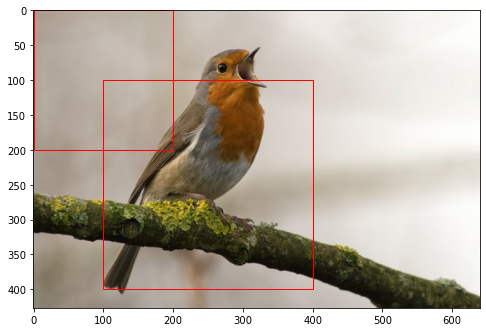

In [28]:
bound_box = np.asarray([[0, 0, 200, 200], [100, 100, 400, 400]], dtype=np.float32)
plot_bbox(image, bound_box) 

In [29]:
bb1 = bound_box[0]
bb2 = bound_box[1]

In [30]:
intersection = np.logical_and(bb1, bb2)
union = np.logical_or(bb1, bb2)
iou_score = np.sum(intersection) / np.sum(union)

In [31]:
iou_score

0.5